<a href="https://colab.research.google.com/github/AurelienCD/Medical_imaging_classification/blob/main/notebook_classification_140kv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-

Connexion au google drive, déplacement dans le dossier contenant les données nécessaires au projet

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Projet scan classification UH

/content/drive/MyDrive/Projet scan classification UH


Importation des librairies nécessaires au projet

In [ ]:
import pandas as pad 
import numpy as np
from numpy.core.numeric import NaN

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics.cluster import adjusted_rand_score

In [ ]:
df = pad.read_csv('extractionCIRS.csv', sep=';')

In [ ]:
df

,label,70,80,100,120,140
0,1,-313.34,-329.78,-353.33,-349,-267.090
1,1,-350.15,-338.68,-356.40,-339,-263.650
2,1,-352.48,-332.41,-363.07,-356,-264.470
3,1,-293.85,-329.68,-345.94,-358,-256.740
4,1,-329.91,-298.65,-340.04,-345,-256.410
...,...,...,...,...,...,...
163115,17,-57.30,-18.70,35.30,-12,-13.300
163116,17,-3.25,12.60,23.50,14,-18.500
163117,17,-12.40,3.13,54.70,-10,15.100
163118,17,-21.40,-43.90,21.40,-12,2.000


In [ ]:
custom_palette = [sns.xkcd_rgb["windows blue"], sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"], "orange", "blue","yellow", "purple", "deeppink", "brown", "teal", "black", sns.xkcd_rgb["windows blue"], sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"], "orange", "blue","yellow"] 
sns.set_palette(custom_palette) 

In [ ]:
color = sns.color_palette()

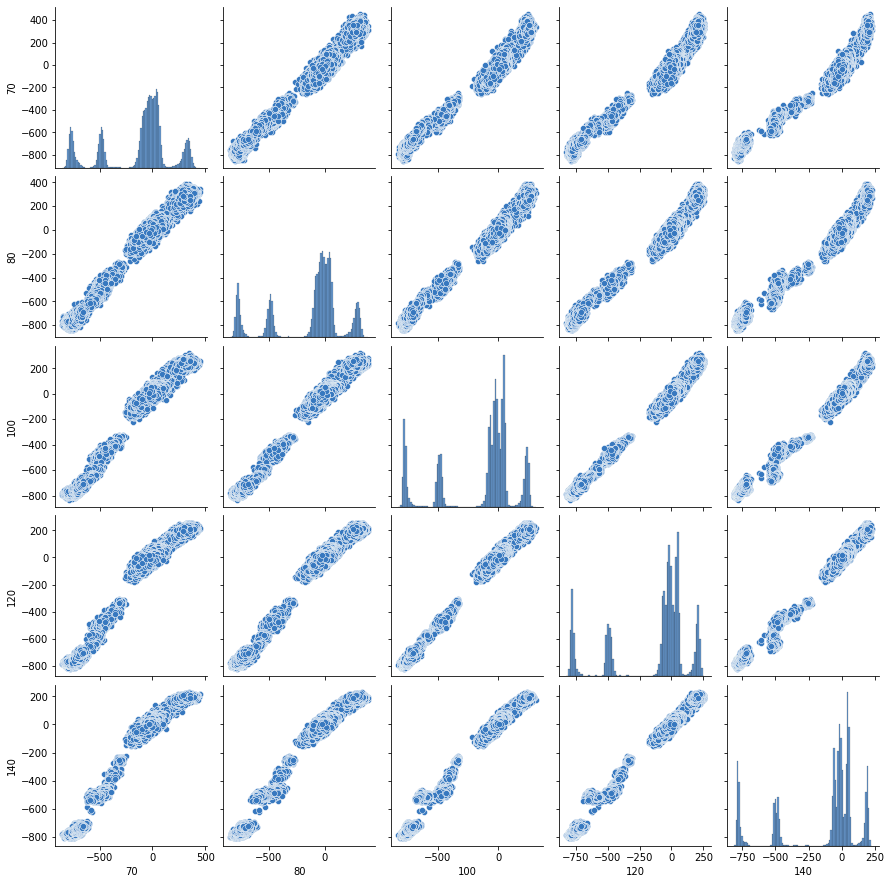

In [ ]:
sns.pairplot(df.drop(columns=['label']))

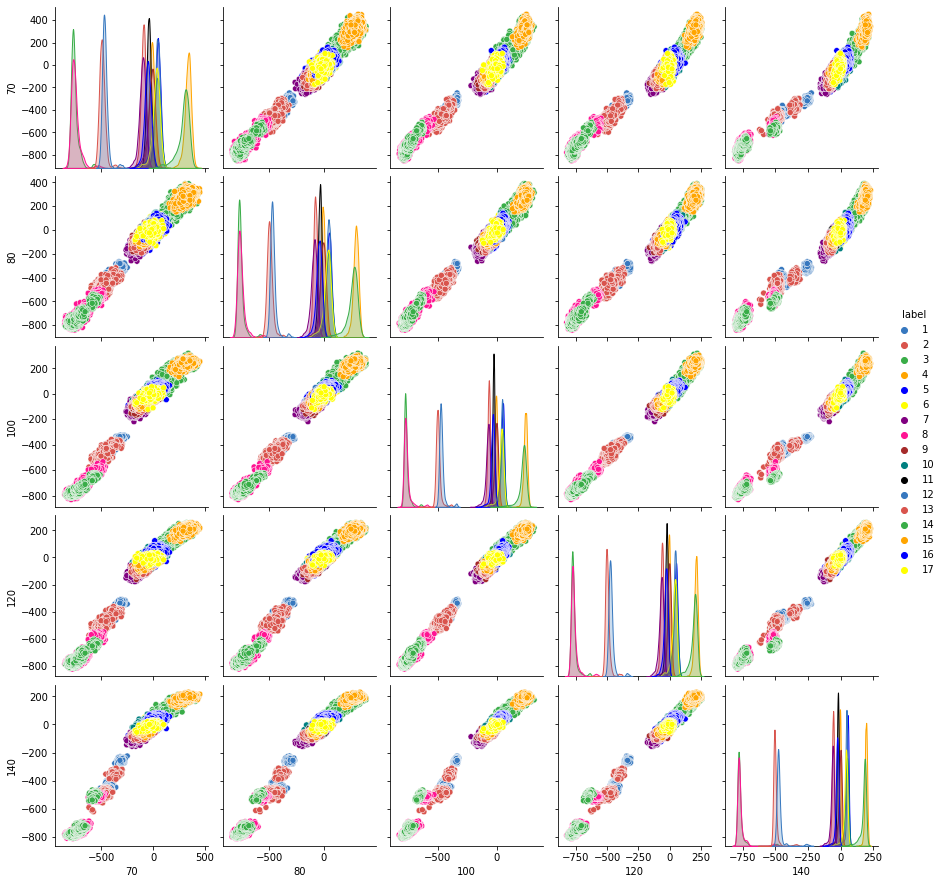

In [ ]:
sns.pairplot(df, hue="label", palette = custom_palette)

In [ ]:
#df_UH_energy = df[["70", "80", "100", "120", "140"]]
#df_UH_energy = df[["80", "140"]]
df_UH_energy = df[["140"]]

In [ ]:
df_UH_energy = df_UH_energy.dropna()

In [ ]:
df_UH_energy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163120 entries, 0 to 163119
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   140     163120 non-null  float64
dtypes: float64(1)
memory usage: 2.5 MB


### Préparation des données

In [ ]:
df_UH_energy.columns

Index(['140'], dtype='object')

Préparation des données quantitatives (standardisation)

In [ ]:
df_UH_energy_scaler = StandardScaler().fit_transform(df_UH_energy)
df_UH_energy_norm = pad.DataFrame(columns = df_UH_energy.columns, data = df_UH_energy_scaler).set_index(df_UH_energy.index)

In [ ]:
df_UH_energy_norm

,140
0,-0.438277
1,-0.426882
2,-0.429598
3,-0.403992
4,-0.402898
...,...
163115,0.402426
163116,0.385200
163117,0.496503
163118,0.453109


Faute de mémoire suffisante, je ne prend qu'une partie du dataset

In [ ]:
df_UH_energy_norm_sample = df_UH_energy_norm.sample(int(df_UH_energy_norm.shape[0]/10), random_state=7).copy()

# Segmentation des inserts par KMeans

### Kmeans

In [ ]:
inertia = {}
dict_kmeans = {}
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, verbose=1, random_state=7).fit(df_UH_energy_norm_sample)
    inertia[k] = kmeans.inertia_
    dict_kmeans[k] = kmeans

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


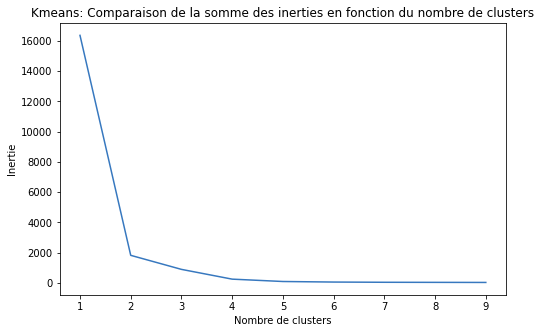

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Kmeans: Comparaison de la somme des inerties en fonction du nombre de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
ax = sns.lineplot(list(inertia.keys()), list(inertia.values()))
fig = ax.get_figure()
fig.savefig("Inertie en fonction du nombre de cluster KMeans_140kv", dpi=400)

On a un coude à 2 et 4 clusters

Métric d'efficacité du clustering : Coefficient de silhouette

In [ ]:
silhouettes_kmeans = {}
for i in range(2,6):
    silhouettes_kmeans[i] = silhouette_score(X = df_UH_energy_norm_sample, labels= list(dict_kmeans[(i)].labels_))

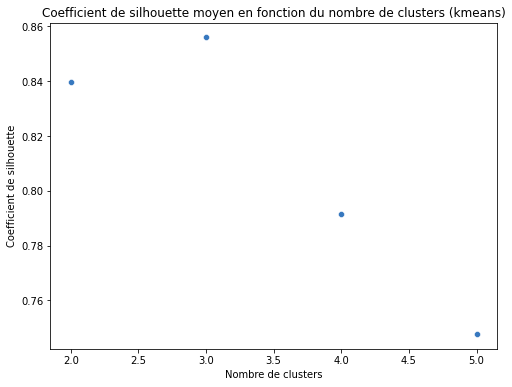

In [ ]:
plt.figure(figsize=(8,6)),
plt.title('Coefficient de silhouette moyen en fonction du nombre de clusters (kmeans)')
ax = sns.scatterplot(x = list(silhouettes_kmeans.keys()), y = list(silhouettes_kmeans.values()))
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de silhouette')
fig = ax.get_figure()
fig.savefig("Coef silhouette en fonction du nombre de cluster KMeans_140kv", dpi=400)
plt.show()

Le nombre de cluster permettant d'obtenir le meilleur coefficient de silhouette est de 3

Métric d'efficacité du clustering : score de davies boulin

In [ ]:
davies_bouldin_kmeans = {}
for i in range(2,10):
    davies_bouldin_kmeans[i] = davies_bouldin_score(X = df_UH_energy_norm_sample, labels= list(dict_kmeans[(i)].labels_))

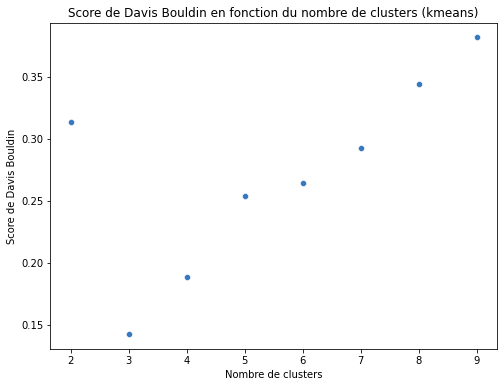

In [ ]:
plt.figure(figsize=(8,6)),
plt.title('Score de Davis Bouldin en fonction du nombre de clusters (kmeans)')
ax = sns.scatterplot(x = list(davies_bouldin_kmeans.keys()), y = list(davies_bouldin_kmeans.values()))
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de Davis Bouldin')
fig = ax.get_figure()
fig.savefig("Score davis Bouldin en fonction du nombre de cluster KMeans_140kv", dpi=400)
plt.show()

Comme pour le coeff de silhouette, le nombre de clusters idéal pour le score de Davis bouldin est 3.

Représentation T-SNE

In [ ]:
tsne = TSNE(n_components=2, perplexity = 30)
T = tsne.fit_transform(df_UH_energy_norm_sample.copy())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


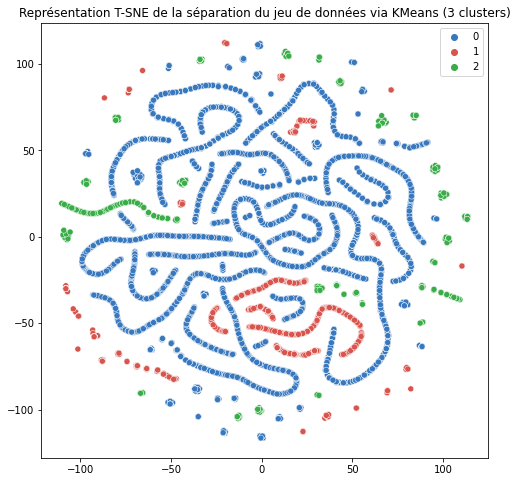

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Représentation T-SNE de la séparation du jeu de données via KMeans (3 clusters)')
ax = sns.scatterplot(T[:,0], T[:,1], hue=dict_kmeans[(3)].labels_, legend='full', palette = custom_palette[:3])
fig = ax.get_figure()
fig.savefig("T-SNE KMeans_3clusters_140kv", dpi=400)

### Clustering Hiérarchique

Pour le clustering hiérarchique, je fais varier le nombre de cluster et je regarde le score de silhouette ainsi que le nombre de cluster proposé

In [ ]:
score_silhouette = []
score_davies_bouldin_clust_hiérar = []
nb_cluster_Clust_hier = []
for i in range(8):
    Clust_hierarchique = AgglomerativeClustering(n_clusters = i+2).fit(df_UH_energy_norm_sample)
    nb_cluster_Clust_hier.append(i+2)
    score_silhouette.append(silhouette_score(X = df_UH_energy_norm_sample, labels= Clust_hierarchique.labels_))
    score_davies_bouldin_clust_hiérar.append(davies_bouldin_score(X = df_UH_energy_norm_sample, labels= Clust_hierarchique.labels_))  

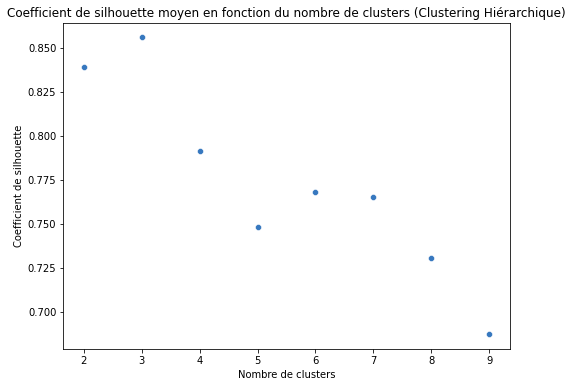

In [ ]:
plt.figure(figsize=(8,6)),
plt.title('Coefficient de silhouette moyen en fonction du nombre de clusters (Clustering Hiérarchique)')
ax = sns.scatterplot(x = nb_cluster_Clust_hier, y = score_silhouette)
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de silhouette')
fig = ax.get_figure()
fig.savefig("Coef silhouette en fonction du nombre de cluster Clustering Hiérarchique_140kv", dpi=400)
plt.show()

Un nombre de cluster de 7 ou 9 semble être optimal au niveau du score de silhouette et potentiellement intéressant pour notre segmentation des clients

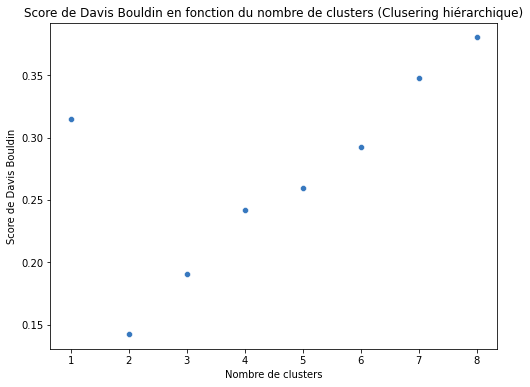

In [ ]:
plt.figure(figsize=(8,6)),
plt.title('Score de Davis Bouldin en fonction du nombre de clusters (Clusering hiérarchique)')
ax = sns.scatterplot(x = np.arange(1,9), y = score_davies_bouldin_clust_hiérar)
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de Davis Bouldin')
fig = ax.get_figure()
fig.savefig("Score davis Bouldin en fonction du nombre de cluster Clust-hiérarchique_140kv", dpi=400)
plt.show()

Ce nombre de cluster de 6 ou 7 semble être optimal ausi au niveau du score de Davis Bouldin

In [ ]:
Clust_hierarchique = AgglomerativeClustering(n_clusters = 3).fit(df_UH_energy_norm_sample)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


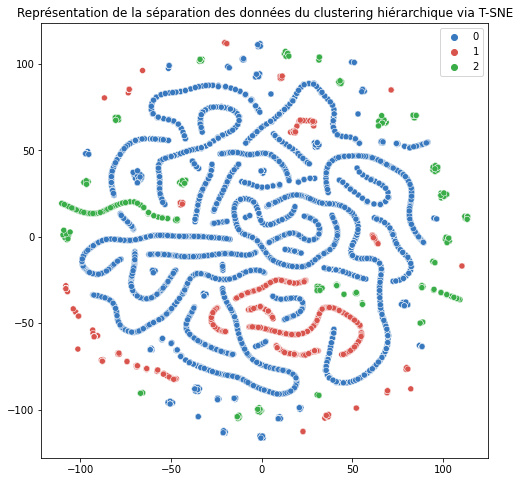

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Représentation de la séparation des données du clustering hiérarchique via T-SNE')
ax = sns.scatterplot(T[:,0], T[:,1], Clust_hierarchique.labels_, palette = custom_palette[:3])
fig = ax.get_figure()
fig.savefig("T-SNE Clustering hiérarchique_140kv", dpi=400)

# Analyse du clutering en fonction des labels initiaux

## Création des databases des résultats

In [ ]:
Clust_hierarchique.labels_.shape

(16312,)

In [ ]:
df_UH_energy_sample = df_UH_energy.sample(int(df_UH_energy.shape[0]/10), random_state=7).copy()

In [ ]:
final_df_UH_clust  = df_UH_energy_sample
final_df_UH_clust["Clustering_hiérarchique"] = Clust_hierarchique.labels_
final_df_UH_clust["Clustering_Kmeans"] = dict_kmeans[(3)].labels_
final_df_UH_clust

,140,Clustering_hiérarchique,Clustering_Kmeans
30540,84.80,0,0
162173,8.23,0,0
80357,-769.00,2,2
138460,-775.00,2,2
143952,-7.96,0,0
...,...,...,...
67296,-51.40,0,0
66437,-56.70,0,0
87927,1.60,0,0
131702,-86.40,0,0


In [ ]:
df_results_keams = pad.DataFrame(index = ["Label 1", "Label 2", "Label 3"])
df_results_clu_hiérar = pad.DataFrame(index = ["Label 1", "Label 2", "Label 3"])

In [ ]:
list_quant_feat = ['140']

Pour connaitre le nombre de point par label

In [ ]:
print("Nombre de point par label pour le Clustering KMeans : ") 
for elm in final_df_UH_clust['Clustering_Kmeans'].unique():
    print(len(final_df_UH_clust[final_df_UH_clust['Clustering_Kmeans'] == elm]['140']))

print("Nombre de point par label pour le Clustering hiérarchique : ")   
for elm in final_df_UH_clust['Clustering_hiérarchique'].unique():
    print(len(final_df_UH_clust[final_df_UH_clust['Clustering_hiérarchique'] == elm]['140']))

Nombre de point par label pour le Clustering KMeans : 
12194
1986
2132
Nombre de point par label pour le Clustering hiérarchique : 
12194
1986
2132


In [ ]:
def print_results_segmentation(feature, clustering):
    print("Pour la classification " + str(clustering) + " est le feature " + str(feature))

    if clustering == "Clustering_Kmeans":
      results= []
      for elm in range(3):
        print("La moyenne du label " + str(elm) + " est de " +str(final_df_UH_clust[final_df_UH_clust[clustering] == elm][feature].mean()))
        results.append(final_df_UH_clust[final_df_UH_clust[clustering] == elm][feature].mean())
      df_results_keams[feature] = results

    if clustering == "Clustering_hiérarchique":
      results= []
      for elm in range(3):
        print("La moyenne du label " + str(elm) + " est de " +str(final_df_UH_clust[final_df_UH_clust[clustering] == elm][feature].mean()))
        results.append(final_df_UH_clust[final_df_UH_clust[clustering] == elm][feature].mean())
      df_results_clu_hiérar[feature] = results

In [ ]:
for elm in list_quant_feat:
    print_results_segmentation(elm, "Clustering_Kmeans")
    print_results_segmentation(elm, "Clustering_hiérarchique")

Pour la classification Clustering_Kmeans est le feature 140
La moyenne du label 0 est de 30.130806084139728
La moyenne du label 1 est de -486.8227954971856
La moyenne du label 2 est de -775.3524672708962
Pour la classification Clustering_hiérarchique est le feature 140
La moyenne du label 0 est de 30.130806084139728
La moyenne du label 1 est de -486.8227954971856
La moyenne du label 2 est de -775.3524672708962


In [ ]:
df_results_keams

,140
Label 1,30.130806
Label 2,-486.822795
Label 3,-775.352467


In [ ]:
df_results_clu_hiérar

,140
Label 1,30.130806
Label 2,-486.822795
Label 3,-775.352467


## Réprésentation graphique des variables d'intérêts

In [ ]:
custom_palette = [sns.xkcd_rgb["windows blue"], sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"], "orange", "blue","yellow", "purple", "deeppink", "brown", "teal", "black"] 
sns.set_palette(custom_palette) 

KMeans

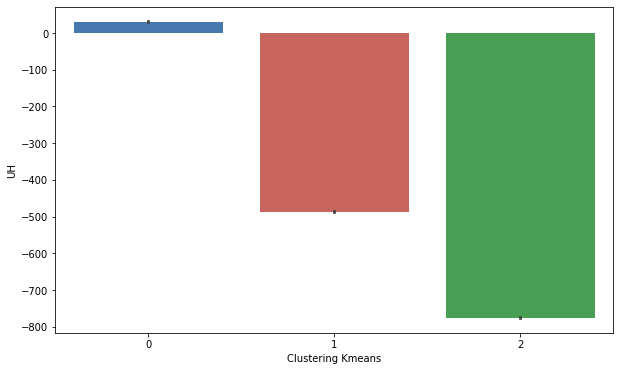

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x = final_df_UH_clust["Clustering_Kmeans"], y = final_df_UH_clust["140"].values, orient='v', palette = custom_palette)
ax.set_xlabel("Clustering Kmeans")
ax.set_ylabel('UH')
ax.set_xticklabels(ax.get_xticklabels())
figure = ax.get_figure()
figure.savefig("Clustering KMeans 140kv", dpi=400)

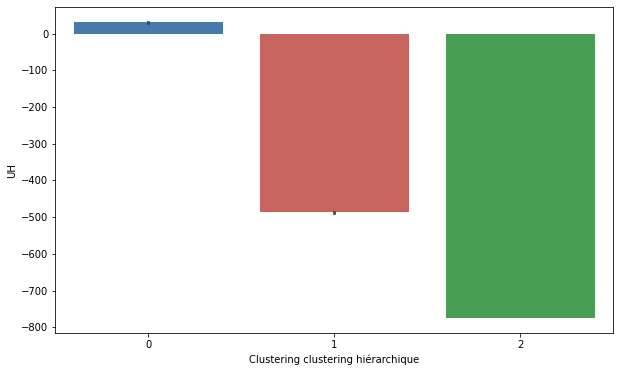

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x = final_df_UH_clust["Clustering_hiérarchique"], y = final_df_UH_clust["140"].values, orient='v', palette = custom_palette)
ax.set_xlabel("Clustering clustering hiérarchique")
ax.set_ylabel('UH')
ax.set_xticklabels(ax.get_xticklabels())
figure = ax.get_figure()
figure.savefig("Clustering clustering hiérarchique 140kv", dpi=400)

# Comparaison des segmentations avec la réalité

In [ ]:
df

,label,70,80,100,120,140
0,1,-313.34,-329.78,-353.33,-349,-267.090
1,1,-350.15,-338.68,-356.40,-339,-263.650
2,1,-352.48,-332.41,-363.07,-356,-264.470
3,1,-293.85,-329.68,-345.94,-358,-256.740
4,1,-329.91,-298.65,-340.04,-345,-256.410
...,...,...,...,...,...,...
163115,17,-57.30,-18.70,35.30,-12,-13.300
163116,17,-3.25,12.60,23.50,14,-18.500
163117,17,-12.40,3.13,54.70,-10,15.100
163118,17,-21.40,-43.90,21.40,-12,2.000


In [ ]:
final_df_UH_clust

,140,Clustering_hiérarchique,Clustering_Kmeans
30540,84.80,0,0
162173,8.23,0,0
80357,-769.00,2,2
138460,-775.00,2,2
143952,-7.96,0,0
...,...,...,...
67296,-51.40,0,0
66437,-56.70,0,0
87927,1.60,0,0
131702,-86.40,0,0


In [ ]:
df_comparaison = pad.merge(df, final_df_UH_clust.drop(['140'], axis=1), left_index=True, right_index=True)

In [ ]:
adjusted_rand_score(df_comparaison['label'], df_comparaison['Clustering_Kmeans'])

0.08606554243022113